In [ ]:
# Copyright © 2018-2021 Intel Corporation All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions
# are met:
#   * Redistributions of source code must retain the above copyright
#     notice, this list of conditions and the following disclaimer.
#   * Redistributions in binary form must reproduce the above copyright
#     notice, this list of conditions and the following disclaimer in
#     the documentation and/or other materials provided with the
#     distribution.
#   * Neither the name of Intel Corporation nor the names of its
#     contributors may be used to endorse or promote products derived
#     from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
# "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
# LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
# A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT
# OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
# SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
# LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
# DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
# THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import tensorflow as tf
from tensorflow.contrib import rnn
import time
import subprocess
import numpy as np
import matplotlib.pyplot as plt

/home/pplank/miniconda3/envs/py36_tf_14_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pplank/miniconda3/envs/py36_tf_14_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pplank/miniconda3/envs/py36_tf_14_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pplank/minico

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Network Parameters
num_input = 1 # MNIST data input (img shape: 28*28)
timesteps = 28*28 # timesteps

sess = tf.Session()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# load a saved model
saver = tf.train.import_meta_graph('./sMNIST_LSTM/sMNIST_standardLSTM.meta')
saver.restore(sess,tf.train.latest_checkpoint('./sMNIST_LSTM/'))

graph = tf.get_default_graph()
X = graph.get_tensor_by_name("X:0")
Y = graph.get_tensor_by_name("Y:0")
accuracy = graph.get_tensor_by_name("accuracy_op:0")

# Calculate accuracy for 128 mnist test images
test_len = 10000
batch_size = 1

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./sMNIST_LSTM/sMNIST_standardLSTM


In [4]:
test_accuracy = []
execution_time = []
image_cnt = 0

# warm up
for i in range(0, 3):
    test_data = mnist.test.images[image_cnt:image_cnt+batch_size].reshape((batch_size, timesteps, num_input))
    test_label = mnist.test.labels[image_cnt:image_cnt+batch_size]
    image_cnt = image_cnt + batch_size
    start = time.time()
    test_accuracy.append(sess.run(accuracy, feed_dict={X: test_data, Y: test_label}))
    end = time.time()
    print("Warmup: ", end-start)

print()
print()
time.sleep(3)

image_cnt = 0
# power measurement
call = "nvidia-smi -i 0 -lms 10 --format=csv,noheader --query-gpu=timestamp,power.draw -f powerusage_smnist.txt"
process = subprocess.Popen(call.split())
time.sleep(5)

for i in range(0, int(test_len/batch_size)):
    test_data = mnist.test.images[image_cnt:image_cnt+batch_size].reshape((batch_size, timesteps, num_input))
    test_label = mnist.test.labels[image_cnt:image_cnt+batch_size]
    image_cnt = image_cnt + batch_size
    start = time.time()
    test_accuracy.append(sess.run(accuracy, feed_dict={X: test_data, Y: test_label}))
    end = time.time()
    execution_time.append(end-start)
    
time.sleep(5)
process.terminate()

print("Testing Accuracy:", np.mean(test_accuracy))
print("Runtime: {:.4f}s ({} samples with batch size {})".format(np.sum(execution_time), test_len, batch_size))
print("Average runtime per batch: {:.4f}ms".format(np.mean(execution_time)*1000))
print("Average runtime per sample: {:.4f}µs".format(np.sum(execution_time)/test_len*1000*1000))

Warmup:  3.303525686264038
Warmup:  0.0396273136138916
Warmup:  0.03912687301635742


Testing Accuracy: 0.102769166
Runtime: 397.3108s (10000 samples with batch size 1)
Average runtime per batch: 39.7311ms
Average runtime per sample: 39731.0826µs


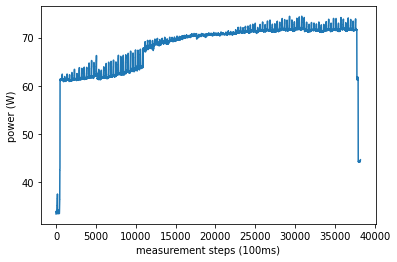

38199


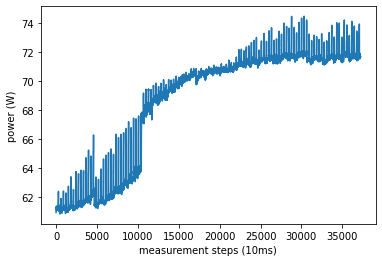

37239
Mean power:  68.49993313461692


In [5]:
results = []

with open('powerusage_smnist.txt') as f:
    lines=f.readlines()
    for line in lines:
        power = float(line.split(',')[1].split('W')[0])
        results.append(power)

plt.figure()
plt.plot(results)
plt.xlabel('measurement steps (100ms)')
plt.ylabel('power (W)')
plt.show()

print(len(results))

workload_start=500
workload_end=-460

plt.figure()
plt.plot(results[workload_start:workload_end])
plt.xlabel('measurement steps (10ms)')
plt.ylabel('power (W)')
plt.show()

print(len(results[workload_start:workload_end]))
print('Mean power: ', np.mean(results[workload_start:workload_end]))

In [6]:
print('Dynamic mean power: ', np.mean(results[0:400]))

Dynamic mean power:  33.92655
